# Regresión logística

El modelo de regresión logística es un modelo gráfico no dirigido que estima una probabilidad de una distribución binaria $X \sim Ber(p)$ donde $p =p(y=1|x)$ es la probabilidad de que el observable $x$ sea parte de la clase y se estima por medio de la función logística:

$$p(y=1|x) = \frac{1}{1+\exp\{-(\theta x + \theta_0\})\}}$$

A partir de aquí se puede predecir una clase que clasifique al vector de entrada. Presentamos una implementación sencilla que utiliza el algoritmo de gradiente descendiente para aprender los pesos.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from seaborn import heatmap
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

## Preparación de los datos

Para probar el método de regresión logística, usamos un dataset sobre cáncer de mama que se puede encontrar en la paquetería de sklearn. Este dataset define un problema de clasificación binario entre la clases es cáncer (1) y no es cáncer (0). El dataset cuenta con diferentes mediciones sobre los tumores. En la descripción del dataset se detalla más sobre estos.

In [2]:
#Carga los datos obtenidos
data = load_breast_cancer()
X = data.data
Y = data.target

pd.DataFrame(X, columns=data.feature_names)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


In [3]:
print(data.DESCR)

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        worst/largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 0 is Mean Radi

Como es común en los datasets, procederemos a separar los datos en entrenamiento y evaluación usando un esquema 70-30; esto es, 70\% para el entrenamiento y 30\% para la evaluación. 

In [4]:
#Separación de los datos
x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.3)

print('Tamaño entrenamiento: {}\nTamaño evaluación: {}'.format(len(x_train), len(x_test)))

Tamaño entrenamiento: 398
Tamaño evaluación: 171


## Aprendizaje en el modelo de regresión logística

Para realizar el aprendizaje en el modelo de regresión logística primero que nada generaremos el modelo, como sabemos el modelo aplica la función logística:

$$f(x) = \frac{1}{1 + e^{-\theta x - \theta_0}}$$

Donde $\theta$ y $\theta_0$ definen los factores del modelo. El objetivo es entonces estimar esto parámetros para que la predicción hecha por el modelo sea correcto.

#### Función logística

Definimos, en principio, la función logística.

In [5]:
#Función logística
logist = lambda a: 1./(1.+np.exp(-a))

La función logística toma valores entre 0 y 1 y puede, por tanto, interpretarse como una probabilidad. En este caso es la probabilidad de que los datos observados pertenezcan a la clase 0. El comportamiento de la función logística es como de S, como puede observarse a continuación.

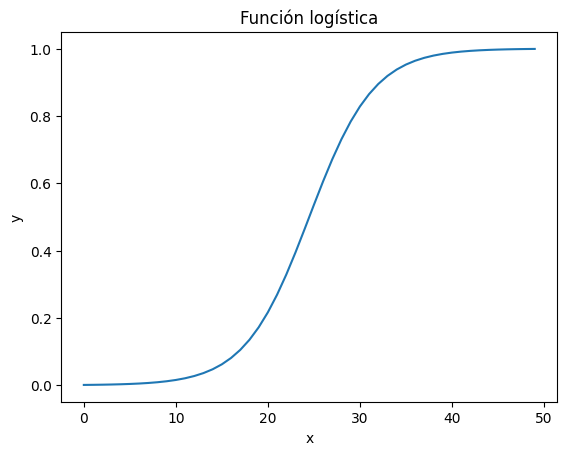

In [6]:
plt.plot(logist(np.linspace(-7,7)))
plt.title('Función logística')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

### Estimación de los parámetros

Para obtener los valores $\theta_i$, $i=\{0,1,...,d\}$ adecuados, usaremos el algoritmo del gradiente descendiente. Este es un algoritmo sencillo que depende del gradiente de una función de costo o riesgo que depende de los parámetros, $R(\theta)$. 

El método del gradiente descendiente actualiza los parámetros con base en el gradiente y en un factor $\eta$ conocido como la tasa de aprendizaje que determina que tanto cambia cada parámetro con respecto al gradiente:

$$\theta_i \leftarrow \theta_i - \eta \nabla_iR(\theta)$$

En el caso de la regresión logística para problemas binarios, nuestra función de costo estará dada por:

$$R(\theta) =  -\Big( y \log p(y=1|x) + (1-y)\log \big( 1- p(y=0|x) \big) \Big)$$

En este caso, la probabilidad se obtiene con la función logística. Notamos que las derivadas parciales (que definen el gradiente) son:

$$\frac{\partial R(\theta)}{\partial \theta_i} (p(y=1|x) - y) x_i$$

Y en el caso de $\theta_0$ se puede denotar que $x_0= 1$ siempre. Por tanto, la actualización de los parámetros se realzará como:

$$\theta_i \leftarrow \theta_i  - \eta \big( f(x) - y \big) \cdot x_i$$

Donde $f(x) = p(y=1|x)$ es la función logística. Para actualizar los parámetros utilizaremos una tasa de aprendizaje $\eta$ e iteraremos varias veces el procedimiento.

Finalmente, una vez obtenido los pesos, podemos estimar las probabilidades de los objetos que estamos trabajando. En este caso, se estima la probabilidad para la clase 1 como $f(x)$ y para la clase 0 obtenemos que se puede sacar de la anterior como $1-f(x)$.

Asimismo, podemos estimar cuál es la clase que mejor se ajusta al dato observable simplemente viendo su probabilidad; si esta supera el 0.5 será de la clase 1, sino pertenecerá a la clase 0.

$$\hat{y} = \begin{cases} 1 & \text{si } f(x) > 0.5 \\ 0 & \text{en otro cas} \end{cases}$$

In [7]:
class LogisticRegression():
    def __init__(self, lr=0.1):
        #Rango de aprendizaje
        self.lr = lr
        #Iniciamos theta_i con 0s
        self.theta = None #np.zeros(d)
        #Iniciamos theta_0 = 0
        self.theta0 = 0
        
    def fit(self, x,y, max_its=10):
        #Tamaño de los datos
        m,d = x.shape
        #Inicializa theta
        self.theta = np.random.rand(d)/np.sqrt(d)
        
        stop = False
        t = 0
        while  stop == False:
            #Revisamos cada uno de los ejemplos
            for x_i, y_i in zip(x,y):
                #Calculamos función logística
                f = logist(np.dot(self.theta,x_i)+self.theta0)
                #Actualizamos los parámetros
                self.theta = self.theta - self.lr*(f-y_i)*x_i
                self.theta0 = self.theta0 - self.lr*(f-y_i)

            t += 1
            #Criterio de paro
            if t > max_its: 
                stop = True
                
    def predict_proba(self, x):
        #Calcula el valor lineal
        a = np.dot(x, self.theta)+self.theta0
        #Aplica la función logística
        f = logist(a)
        
        return f
    

    def predict(self, x):
        #Obtiene probabilidades
        prob = self.predict_proba(x)
        #Obtiene las clases
        y_pred = 1*(prob > 0.5)
        
        return y_pred

### Entrenamiento del modelo

El entrenamiento del modelo consistirá en aprender los parámetros $\theta \in \mathbb{R}^d$ y $\theta_0 \in \mathbb{R}$ que definen las estimación de las probabilidades. Para hacer esto, utilizamos la clase anteriormente definida; determinamos una tasa de aprendizaje adecuada para los datos y determinamos un número máximo de iteraciones por las que repetirá el proceso de aprendizaje. Más adelante, analizaremos los parámetros que el modelo aprendió.

In [8]:
#Genera el modelo
model = LogisticRegression(lr=1e-5)
#Entrena el modelo
model.fit(x_train, y_train, max_its=100)

### Evaluación del modelo

El modelo de regresión logística no obtiene una clase como salida, sino una probabilidad. Esta probabilidad está definida como:

$$p(Y=1|x)  = \frac{1}{1+\exp\{-(\theta x +\theta_0)\}}$$

Y determina la probabilidad que la clase sea 1. El modelo de regresión logística asume que los datos de entrada pertenecen a clases binarias; es decir, asumen que la variable $Y$ toma sólo los valores 0 y 1. Por tanto, es fácil obtener la probabilidad de la clase 0 como: $$p(Y=0|x) = 1-p(Y=1|x)$$
De esta forma, podemos obtener las probabilidades para ambas clases.

Asimismo, podemos elegir una clase según la probabilidad. Claramente tenemos que la clase se puede determinar por medio de la probabilidad como:

$$\hat{y} = \arg\max_y p(Y=y|x) = \begin{cases} 1 & \text{si } p(Y=1|x) > 0.5 \\ 0 & \text{en otro caso} \end{cases}$$

In [9]:
#Obtiene probabilidades
probs = model.predict_proba(x_test)
#Obtiene clases
y_pred = model.predict(x_test)

datos = pd.DataFrame(data=np.array([probs, 1-probs]).T, columns=['Prob. clase 1', 'Prob. clase 0'])
datos['Clase real'] = y_test
datos['Clase predicha'] = y_pred
datos

,Prob. clase 1,Prob. clase 0,Clase real,Clase predicha
0,9.996827e-01,3.173013e-04,1,1
1,9.999051e-01,9.492659e-05,1,1
2,9.999898e-01,1.020091e-05,1,1
3,9.999486e-01,5.140995e-05,1,1
4,9.969000e-01,3.099999e-03,1,1
...,...,...,...,...
166,9.999995e-01,5.480492e-07,1,1
167,5.978483e-39,1.000000e+00,0,0
168,6.312620e-26,1.000000e+00,0,0
169,9.999952e-01,4.762449e-06,1,1


Finalmente, podemos evaluar qué tan bien realiza la clasificación con las métricas usuales. Tal como podemos ver, el modelo hace una clasificación bastante satisfactoria.

In [10]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.93      0.79      0.85        63
           1       0.89      0.96      0.92       108

    accuracy                           0.90       171
   macro avg       0.91      0.88      0.89       171
weighted avg       0.90      0.90      0.90       171



### Estado de creencias del modelo

Los parámetros $\theta_i$ determinan los factores del modelo, pero también nos dan información sobre el estado de creencias del modelo. Pues cada uno de los parámetros está asociado a una variable observable $x_i$; por tanto, entre mayor sea el valor de este $\theta_i$ para ese observable, mayor será el valor que el modelo le da a este observable para decidir que pertenece a la clase ($y=1$).

,$\theta_i$
mean radius,0.137039
mean texture,0.070019
mean perimeter,0.246242
mean area,0.063097
mean smoothness,0.072480
mean compactness,-0.001184
mean concavity,0.110297
mean concave points,0.174284
mean symmetry,0.087873
mean fractal dimension,0.101881


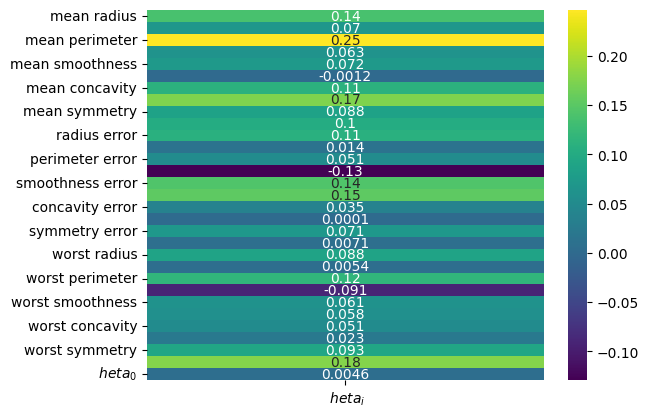

In [11]:
#DataFrame de los parámetros
beliefs = pd.DataFrame(data=np.append(model.theta,model.theta0),index=list(data.feature_names)+[' $\theta_0$'],columns=[' $\theta_i$'])
#Mapa de calor
heatmap(beliefs, annot=True, cmap='viridis')
beliefs